In [1]:
import os
import random
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import torch
from torchvision import datasets
from PIL import Image
from tqdm import tqdm


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

OUTPUT_DIR = "colored_mnist"
DATA_DIR = "./data"

BIAS_PROB = 0.95
NOISE_LEVEL = 20


In [3]:
DIGIT_TO_COLOR = {
    0: (255, 0, 0),      # Red
    1: (0, 255, 0),      # Green
    2: (0, 0, 255),      # Blue
    3: (255, 255, 0),    # Yellow
    4: (128, 0, 128),    # Purple
    5: (255, 165, 0),    # Orange
    6: (0, 255, 255),    # Cyan
    7: (255, 0, 255),    # Magenta
    8: (165, 42, 42),    # Brown
    9: (255, 192, 203)   # Pink
}


In [4]:
def textured_background(color, h, w, noise=20):
    base = np.ones((h, w, 3), dtype=np.float32)
    base *= np.array(color, dtype=np.float32)

    noise_map = np.random.randint(
        -noise, noise + 1, size=(h, w, 3)
    ).astype(np.float32)

    bg = np.clip(base + noise_map, 0, 255)
    return bg.astype(np.uint8)


In [5]:

def colorize_mnist(mnist_img, color, noise=20):
    img = np.array(mnist_img, dtype=np.uint8)
    h, w = img.shape

    bg = textured_background(color, h, w, noise)

    digit_mask = img > 30
    digit = 255 - img
    digit = np.clip(digit, 180, 255)

    digit_rgb = np.stack([digit]*3, axis=2)

    result = bg.copy()
    result[digit_mask] = digit_rgb[digit_mask]

    return result.astype(np.uint8)



In [6]:
def choose_color_easy(label):
    if random.random() < BIAS_PROB:
        return DIGIT_TO_COLOR[label]
    else:
        others = [d for d in range(10) if d != label]
        return DIGIT_TO_COLOR[random.choice(others)]

def choose_color_hard(label):
    others = [d for d in range(10) if d != label]
    return DIGIT_TO_COLOR[random.choice(others)]


In [7]:
def create_colored_dataset(mnist, split_name, easy=True):
    base_path = Path(OUTPUT_DIR) / "type2_background" / split_name
    base_path.mkdir(parents=True, exist_ok=True)

    for d in range(10):
        (base_path / str(d)).mkdir(exist_ok=True)

    stats = defaultdict(Counter)
    counts = defaultdict(int)

    for i in tqdm(range(len(mnist))):
        img, label = mnist[i]

        if easy:
            color = choose_color_easy(label)
        else:
            color = choose_color_hard(label)

        colored = colorize_mnist(img, color, NOISE_LEVEL)

        fname = f"{label}_{counts[label]:05d}.png"
        Image.fromarray(colored).save(base_path / str(label) / fname)

        counts[label] += 1
        stats[label][color] += 1

    return stats, counts


In [8]:
train_mnist = datasets.MNIST(
    root=DATA_DIR,
    train=True,
    download=True
)

test_mnist = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True
)

len(train_mnist), len(test_mnist)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.94MB/s]


(60000, 10000)

In [9]:
easy_stats, easy_counts = create_colored_dataset(
    train_mnist,
    split_name="easy_train",
    easy=True
)


100%|██████████| 60000/60000 [00:46<00:00, 1304.25it/s]


In [10]:
hard_stats, hard_counts = create_colored_dataset(
    test_mnist,
    split_name="hard_test",
    easy=False
)


100%|██████████| 10000/10000 [00:07<00:00, 1299.06it/s]


In [11]:
def print_bias_stats(stats, counts, name):
    print(name.upper())
    print("-" * 60)
    print("Digit | Dominant Color Count | Total | Percent")
    print("-" * 60)

    for d in range(10):
        dom = DIGIT_TO_COLOR[d]
        dom_count = stats[d][dom]
        total = counts[d]
        pct = (dom_count / total) * 100 if total > 0 else 0
        print(f"{d:>5} | {dom_count:>21} | {total:>5} | {pct:6.2f}%")

print_bias_stats(easy_stats, easy_counts, "Easy Train")
print()
print_bias_stats(hard_stats, hard_counts, "Hard Test")


EASY TRAIN
------------------------------------------------------------
Digit | Dominant Color Count | Total | Percent
------------------------------------------------------------
    0 |                  5615 |  5923 |  94.80%
    1 |                  6409 |  6742 |  95.06%
    2 |                  5692 |  5958 |  95.54%
    3 |                  5835 |  6131 |  95.17%
    4 |                  5521 |  5842 |  94.51%
    5 |                  5138 |  5421 |  94.78%
    6 |                  5642 |  5918 |  95.34%
    7 |                  5959 |  6265 |  95.12%
    8 |                  5565 |  5851 |  95.11%
    9 |                  5657 |  5949 |  95.09%

HARD TEST
------------------------------------------------------------
Digit | Dominant Color Count | Total | Percent
------------------------------------------------------------
    0 |                     0 |   980 |   0.00%
    1 |                     0 |  1135 |   0.00%
    2 |                     0 |  1032 |   0.00%
    3 |         

In [ ]:
import matplotlib.pyplot as plt

sample_dir = Path(OUTPUT_DIR) / "type2_background" / "easy_train" / "7"
sample_img = Image.open(list(sample_dir.glob("*.png"))[0])

plt.imshow(sample_img)
plt.axis("off")


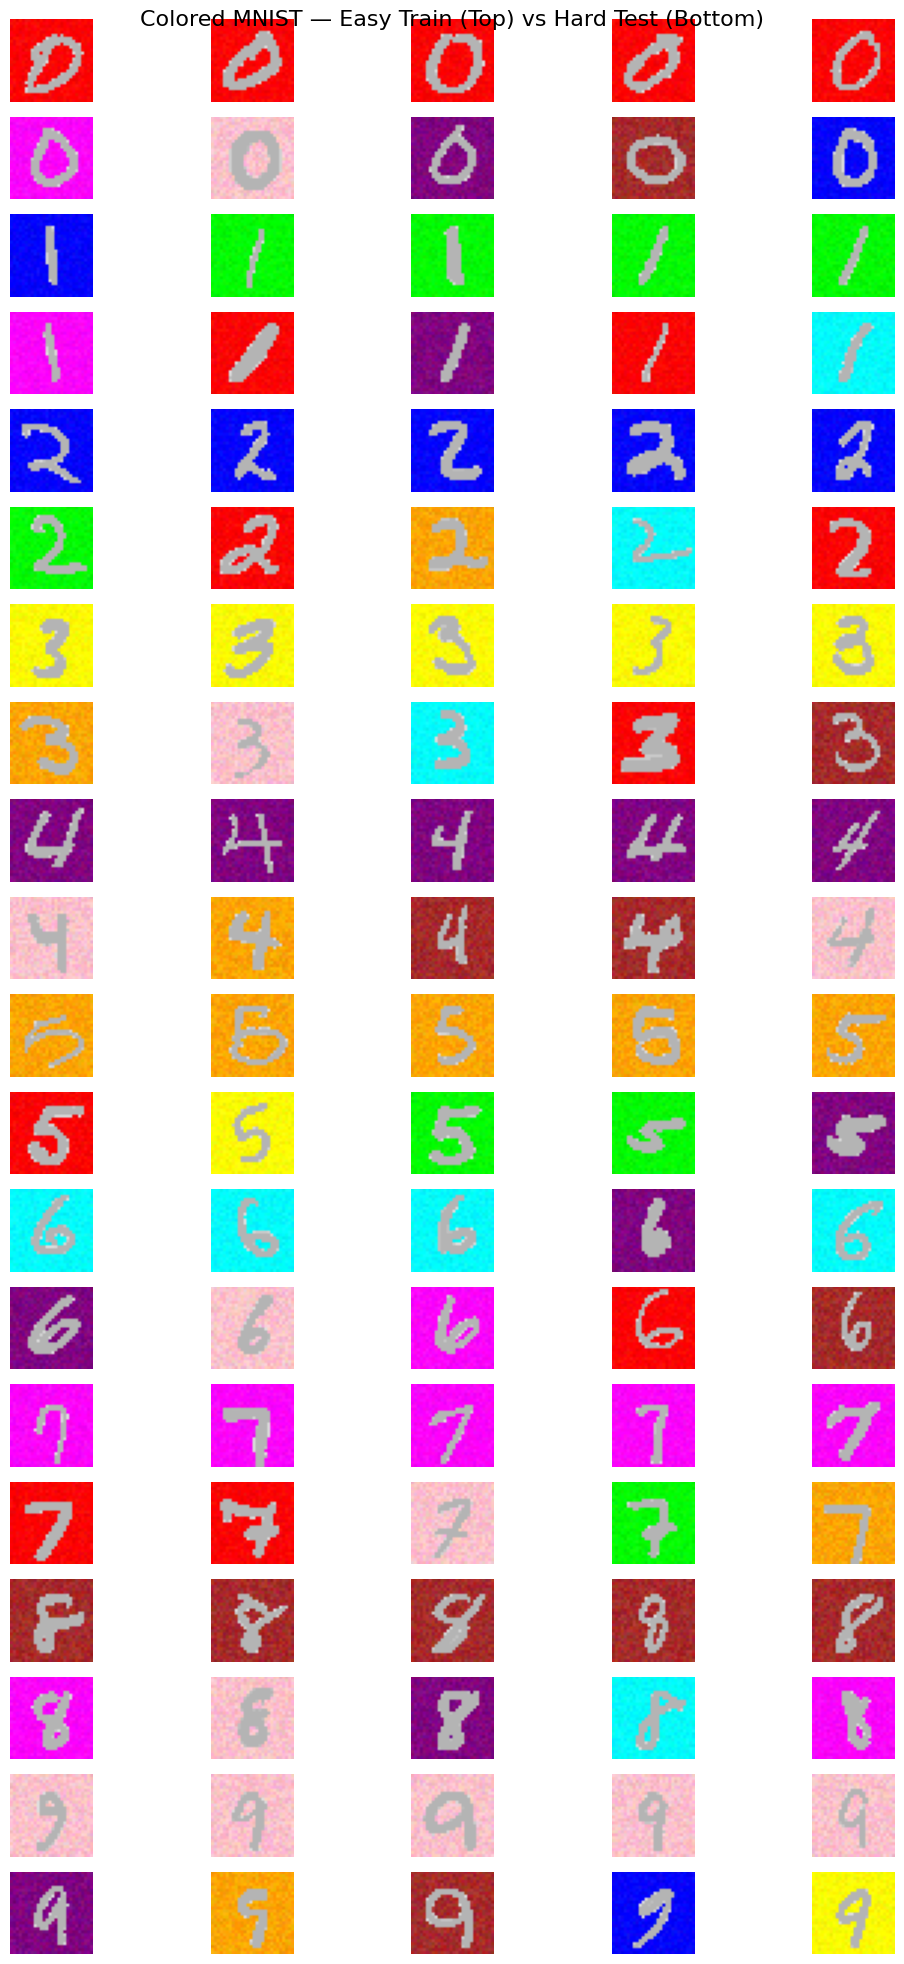

In [12]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random

easy_root = Path(OUTPUT_DIR) / "type2_background" / "easy_train"
hard_root = Path(OUTPUT_DIR) / "type2_background" / "hard_test"

NUM_SAMPLES = 5  # images per digit per split

fig, axes = plt.subplots(
    nrows=20,      # 10 digits × (easy + hard)
    ncols=NUM_SAMPLES,
    figsize=(NUM_SAMPLES * 2.2, 20)
)

row = 0
for digit in range(10):
    easy_imgs = list((easy_root / str(digit)).glob("*.png"))
    hard_imgs = list((hard_root / str(digit)).glob("*.png"))

    easy_samples = random.sample(easy_imgs, NUM_SAMPLES)
    hard_samples = random.sample(hard_imgs, NUM_SAMPLES)

    # Easy row
    for col, img_path in enumerate(easy_samples):
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        if col == 0:
            axes[row, col].set_ylabel(f"Easy {digit}", fontsize=12)

    row += 1

    # Hard row
    for col, img_path in enumerate(hard_samples):
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        if col == 0:
            axes[row, col].set_ylabel(f"Hard {digit}", fontsize=12)

    row += 1

plt.suptitle("Colored MNIST — Easy Train (Top) vs Hard Test (Bottom)", fontsize=16)
plt.tight_layout()
plt.show()
